In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import json
from matplotlib.backends.backend_pdf import PdfPages

import sys
sys.path.append('../../silica_opt_insilico/src/silica_opt_insilico/')
import pd_utils
import matplotlib.ticker as ticker

import glob
from scipy.signal import find_peaks, peak_widths, peak_prominences
from matplotlib.ticker import FormatStrFormatter

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
#import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
import xgboost

## Load constants and filepaths

In [4]:
with open('../APS/Mesoporous_constants_APS_batch.json', 'rt') as f:
    constants = json.load(f)

In [5]:
data_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS"
usaxs_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/BatchSamplesData/Reduced_ascii_4_18_25_emptyBlank_renamed"

In [6]:
paths = os.listdir(data_fp)
usaxs_paths = os.listdir(usaxs_fp)

In [7]:
# load usaxs data

In [8]:
sample_table = pd.read_csv("/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/APS_sample_reference_cartridgebatch.csv")

In [9]:
composition_table = pd.read_csv('../APS/Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv').set_index('uuid', drop=True)

In [10]:
def get_composition(row, teos_dilution_ratio, ctab_concentration, f127_concentration):
    teos_volume = row['teos_volume']
    ammonia_volume = row['ammonia_volume']
    water_volume = row['water_volume']
    ethanol_volume = row['ethanol_volume']
    ctab_volume = row['ctab_volume']
    F127_volume = row['F127_volume']

    total_volume = teos_volume + ammonia_volume + water_volume + ethanol_volume + ctab_volume + F127_volume
    print('Total volume: ', total_volume)
    
    ammonia_vf = ammonia_volume/total_volume
    water_delivered_vf = water_volume / total_volume
    ethanol_delivered_vf = ethanol_volume/total_volume
    ctab_vf = ctab_volume/total_volume
    F127_vf = F127_volume/total_volume


    ## Need to correct for mixed compositions

    # TEOS and ethanol:
    teos_vf = teos_volume/teos_dilution_ratio/total_volume
    teos_etoh_vf = teos_volume*((teos_dilution_ratio - 1)/teos_dilution_ratio)/total_volume

    ethanol_vf = ethanol_delivered_vf + teos_etoh_vf

    print('Ethanol delivered vf: ', ethanol_delivered_vf)
    print('Ethanol TEOS vf: ', teos_etoh_vf)
    print('Total ethanol vf: ', ethanol_vf)

    

    water_vf = water_delivered_vf + F127_vf + ctab_vf

    ctab_mass = ctab_volume * ctab_concentration
    f127_mass = F127_volume * f127_concentration

    # 

    return {'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'water_vf':water_vf, 'ethanol_vf':ethanol_vf, 'ctab_mass':ctab_mass, 'F127_mass':f127_mass}

In [11]:
def get_filename(stub, paths):
    for path in paths:
        if stub in path:
            return path

In [12]:
sobolbatch_samples = {}
teos_dilution_ratio = constants['TEOS']['dilution_ratio']
ctab_concentration = constants['ctab']['stock_concentration_mg_uL']
f127_concentration = constants['f127']['stock_concentration_mg_uL']

for i, row in sample_table.iloc[0:73].iterrows():
    sample = {}
    sample['sample_name'] = row['Sample name']
    sample['cartridge_number'] = row['Cartridge plate']
    sample['cartridge_cell'] = row['Cartridge cell']
    sample_uid = row['Sample ID']


    if sample_uid is not np.nan:
        
        filename = glob.glob(os.path.join(data_fp, f'*{sample_uid}*'))
        usaxs_filename = glob.glob(os.path.join(usaxs_fp, f'*{sample_uid}*'))
        print(filename)
        if len(filename) == 0:
            print(f'Warning: No files found for sample {sample_uid}')
            continue
    
        else:
                
            sample['data'] = io.read_1D_data(filename[0])
            sample['usaxs_data'] = pd.read_csv(usaxs_filename[0], sep = '\t')


        composition_row = composition_table.loc[sample_uid]
        composition = get_composition(composition_row, teos_dilution_ratio, ctab_concentration, f127_concentration)
        sample['composition'] = composition
        sobolbatch_samples[sample_uid] = sample


        


        
    

[]
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04247_A4-T2_93780a39-35f5-4c85-963b-2fde66396c78_000_sub_merged_merged.dat']
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04250_A5-T2_00afc63f-86d3-41a0-9f37-8d56c6d1abfd_000_sub_merged_merged.dat']
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2025_04_11_APSbatchMAXS/merged_emptyblank/ESAXS_SAXS_MAXS/04251_A6-T2_83caa81b-c9ac-4b2f-b7b6-97a05c42f277_000_sub_merged_merged.dat']
Total volume:  10000.0
Ethanol deli

In [13]:
phase_table = pd.read_csv('APS_sample_mesophase.csv')

In [14]:
sobolbatch_samples.keys()

dict_keys(['93780a39-35f5-4c85-963b-2fde66396c78', '00afc63f-86d3-41a0-9f37-8d56c6d1abfd', '83caa81b-c9ac-4b2f-b7b6-97a05c42f277', '285271f3-055d-4edd-9cdd-3322ed1140ed', '8f86f557-5b97-4a80-b8da-55a55056d4b5', '0491adba-e277-4475-aee0-af111005fd40', '586e06c8-0f02-43a3-9f2f-81e46d43ef64', '0ac06a89-aaee-42bd-b133-7ce04e6bf11f', '6ccabe6a-7601-4172-9afb-6028e52b540f', 'a28ca6e8-5b6d-4d46-a3d1-69adf978666f', 'f2abcc4b-a35e-4ca7-9c30-dc187315c057', '33751e55-4c10-44a5-b19d-41f69614c062', 'c5ce72e5-18c6-44cb-b802-1ee061e79d7c', 'adaea14a-020d-4c48-969b-22082efaa360', 'cd68d12d-ea08-41fe-9fa3-5bc3d19ca2b4', '771f50cf-950d-4109-abb4-9f9448a7bd0c', '2a9314bf-982c-4890-8572-e8f337974424', '74cf78f3-80a0-42f1-b2b4-57440d3d9296', '9f37e277-1e73-4eb9-a857-2d6fe238f274', '6dde1870-e4c4-4292-b873-c65e90257639', '1c775223-74ff-4c55-9018-cc6c61ad0bb5', 'b868fcd1-5112-4d16-9894-e09a60b6f861', '2a5fedcc-7647-475d-823a-2ed8541dd082', 'a9cf5a76-d5b7-40ab-889a-d21648ad39dd', '5afc4fb5-83e3-457d-b446-53fd

In [15]:
sobolbatch_samples["5dfdbe5e-3f38-44de-b9db-65c72c27f02e"]

KeyError: '5dfdbe5e-3f38-44de-b9db-65c72c27f02e'

## Plot scattering

In [34]:
sample = list(sobolbatch_samples.values())[0]

In [35]:
q = sample['data'][0]['q']
I = sample['data'][0]['I']

In [36]:
peaks = find_peaks(np.log10(I), prominence=0.08)

/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


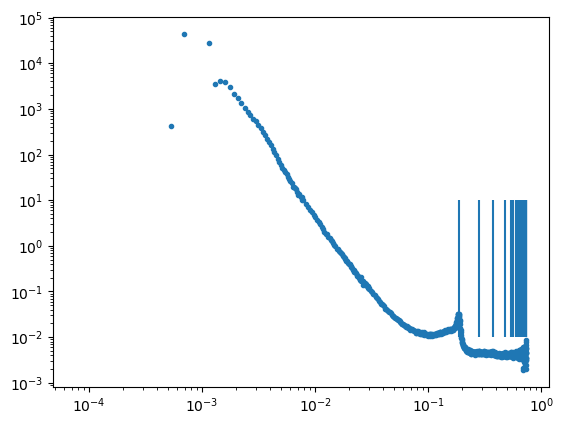

In [37]:
fig, ax = plt.subplots()
ax.loglog(q, I, ls = '', marker = '.')
for peak in peaks[0]:
    ax.vlines(q[peak], 1e-2, 1e1) 

In [38]:
sample_table

,Sample name,Sample ID,Vial number,Box location,Cartridge plate,Cartridge cell,Loaded?
0,Water blank,NaN,NaN,NaN,1.0,A1,y
1,Empty cell blank,NaN,NaN,NaN,1.0,A2,y
2,SobolBatch_control_1,5dfdbe5e-3f38-44de-b9db-65c72c27f02e,5,A1,1.0,A3,y
3,SobolBatch_control_2,93780a39-35f5-4c85-963b-2fde66396c78,7,A2,1.0,A4,y
4,SobolBatch_control_3,00afc63f-86d3-41a0-9f37-8d56c6d1abfd,9,A3,1.0,A5,y
...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
def cubic_peaks(p0):
    return [p0, np.sqrt(4/3)*p0, np.sqrt(7/3)*p0, np.sqrt(8/3)*p0, np.sqrt(10/3)*p0, np.sqrt(11/3)*p0]

def hex_peaks(p0):
    return [p0, np.sqrt(3)*p0, np.sqrt(4)*p0, np.sqrt(7)*p0]

def bcc_peaks(p0):
    return [p0, np.sqrt(2)*p0, np.sqrt(3)*p0, np.sqrt(4)*p0, np.sqrt(5)*p0]

def fcc_peaks(p0):
    return [p0, np.sqrt(4/3)*p0, np.sqrt(8/3)*p0, np.sqrt(11/3)*p0, np.sqrt(12/3)*p0]

In [40]:
def get_phasecolor(p0, phase_break_1, phase_break_2):
    if p0 < phase_break_1:
        return 'red'
    elif p0 < phase_break_2:
        return 'blue'
    else:
        return 'green'

In [41]:
phase_table = phase_table.set_index(['Sample name'])

In [42]:
phase_table.loc['SobolBatch_control_2']['Brenden Phase ID']

'Peak'

In [43]:
phase_table

,Brenden Phase ID,Unnamed: 2
Sample name,,
Water blank,-,NaN
Empty cell blank,-,NaN
SobolBatch_control_1,-,NaN
SobolBatch_control_2,Peak,NaN
SobolBatch_control_3,Peak,NaN
...,...,...
SobolBatch_59,Peak,NaN
SobolBatch_60,No peak,NaN
SobolBatch_61,Peak,NaN


In [44]:
phase_break_1 = 0.17
phase_break_2 = 0.2

/tmp/ipykernel_1959/3787526843.py:13: RuntimeWarning: invalid value encountered in log10
  peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]


(array([0.02163884]), array([0]), array([774]))
Peak
(array([0.02201028]), array([2]), array([772]))
Peak
(array([0.02577777]), array([61]), array([774]))
Peak
(array([0.06226674]), array([13]), array([774]))
Peak
(array([0.00841226]), array([88]), array([759]))
Peak
(array([0.00398554]), array([17]), array([774]))
Peak
(array([0.06155745]), array([8]), array([774]))
Hex
(array([0.01123851]), array([22]), array([773]))
Peak
(array([0.0216583]), array([6]), array([774]))
Peak
(array([0.06122317]), array([0]), array([774]))
Peak
(array([0.00680292]), array([10]), array([774]))
Peak
(array([0.00436546]), array([76]), array([773]))
Peak
(array([0.02583569]), array([1]), array([774]))
Peak
(array([0.04322156]), array([2]), array([774]))
Hex
(array([0.00170441]), array([29]), array([663]))
No peak
(array([0.00072969]), array([510]), array([528]))
Peak
(array([0.01509716]), array([17]), array([773]))
Peak
(array([0.01258578]), array([3]), array([773]))
Peak
(array([0.01014604]), array([18]), 

/tmp/ipykernel_1959/3787526843.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


(array([0.04583824]), array([12]), array([774]))
Cubic
(array([0.00465279]), array([4]), array([773]))
Peak
(array([0.00348309]), array([7]), array([766]))
Peak
(array([0.00294294]), array([84]), array([774]))
Peak
(array([0.2480503]), array([2]), array([772]))
Hex
(array([0.01455019]), array([3]), array([774]))
Peak
(array([0.03041947]), array([20]), array([774]))
Peak
(array([0.02515478]), array([11]), array([774]))
Peak
(array([0.005159]), array([73]), array([773]))
Peak
(array([0.04253794]), array([0]), array([773]))
Hex
(array([0.06818656]), array([6]), array([774]))
Cubic
(array([0.00074717]), array([359]), array([380]))
No peak
(array([0.02224605]), array([1]), array([773]))
Peak
(array([0.0102613]), array([5]), array([773]))
Peak
(array([0.06521093]), array([1]), array([774]))
No ID - 2 peaks
(array([0.00896207]), array([3]), array([773]))
No peak
(array([0.00465682]), array([22]), array([762]))
No peak
(array([0.01348079]), array([4]), array([768]))
Peak
(array([0.01576556]), 

/tmp/ipykernel_1959/3787526843.py:20: PeakPropertyWarning: some peaks have a prominence of 0
  width_vals = peak_widths(I, [peak_ind])
/tmp/ipykernel_1959/3787526843.py:20: PeakPropertyWarning: some peaks have a width of 0
  width_vals = peak_widths(I, [peak_ind])
/tmp/ipykernel_1959/3787526843.py:21: PeakPropertyWarning: some peaks have a prominence of 0
  prom_vals = peak_prominences(I, [peak_ind])
/tmp/ipykernel_1959/3787526843.py:50: RuntimeWarning: invalid value encountered in scalar divide
  sharp_score = prominence/peak_width_q


(array([0.01513462]), array([0]), array([774]))
Peak
(array([0.00658055]), array([12]), array([774]))
Peak
(array([0.0323833]), array([54]), array([774]))
No ID - 2 peaks
(array([0.05667013]), array([3]), array([774]))
No ID - 2 peaks
(array([0.00929873]), array([12]), array([774]))
Peak
error for sample SobolBatch_60, index 0 is out of bounds for axis 0 with size 0
(array([0.]), array([84]), array([769]))
No peak
(array([0.013249]), array([2]), array([774]))
Peak
(array([0.01753097]), array([5]), array([769]))
Hex
(array([0.02299112]), array([5]), array([758]))
Peak


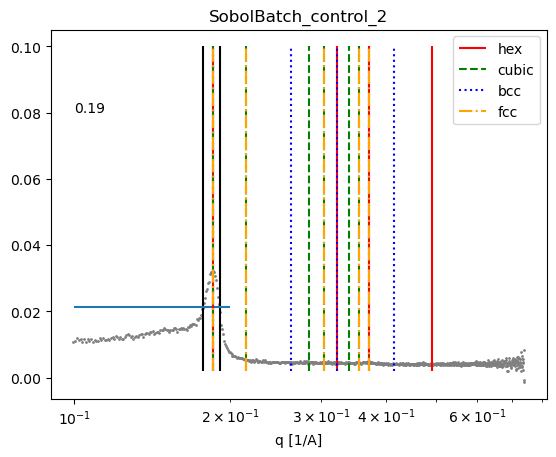

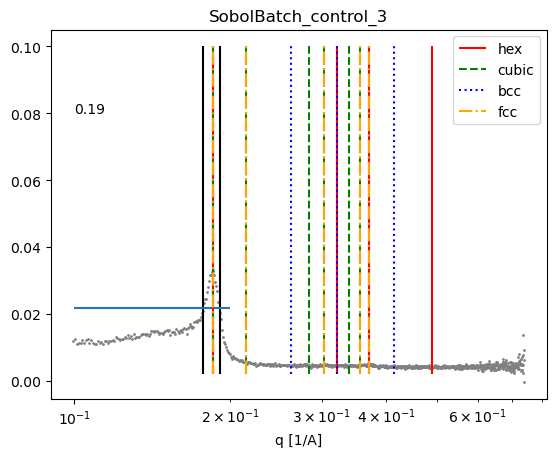

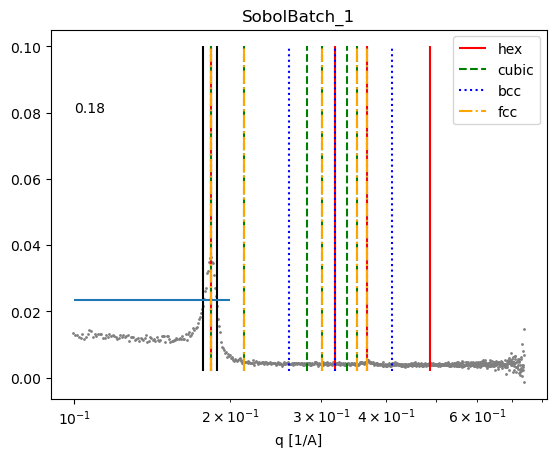

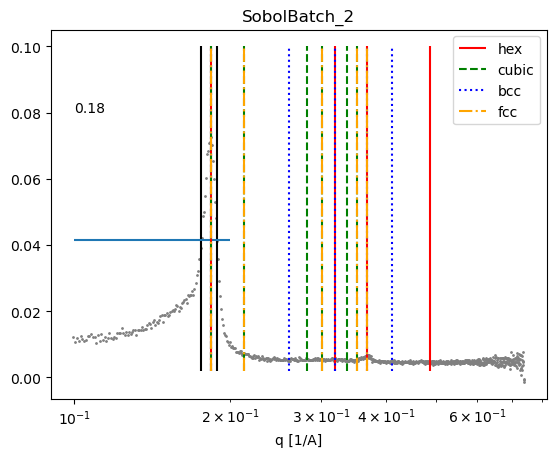

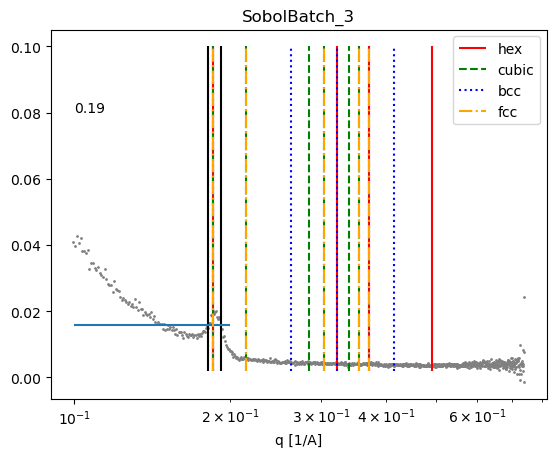

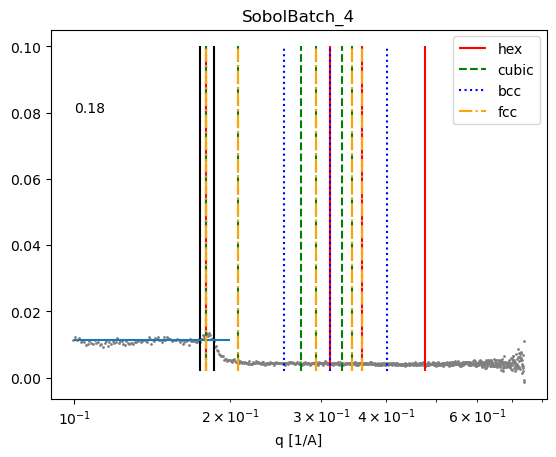

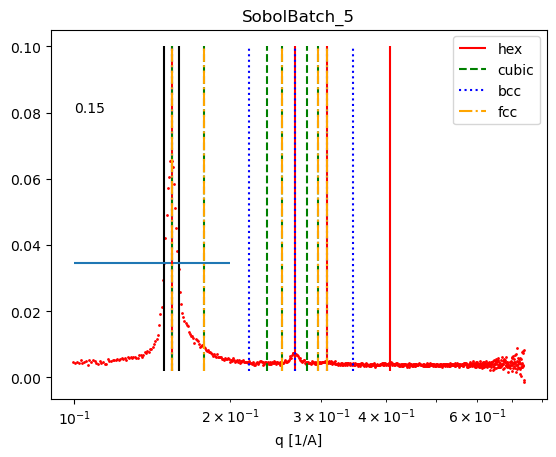

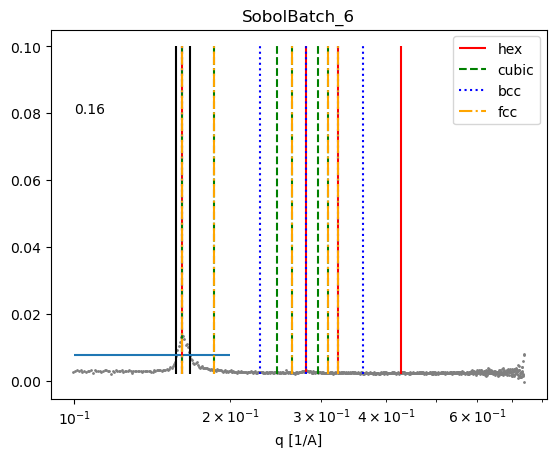

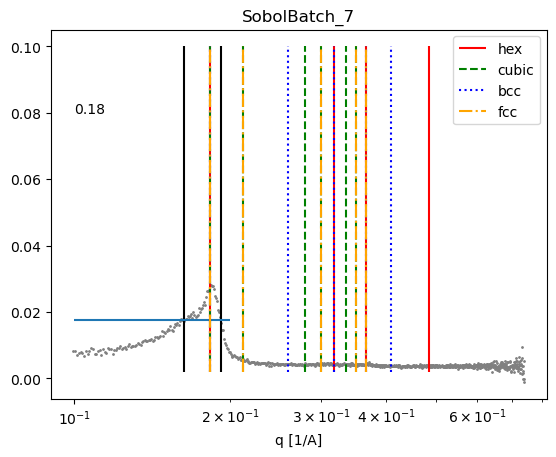

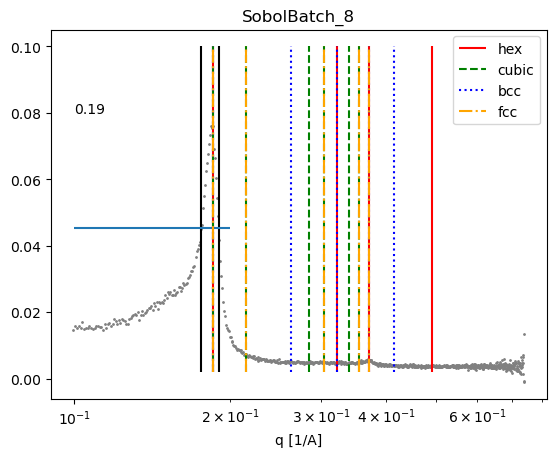

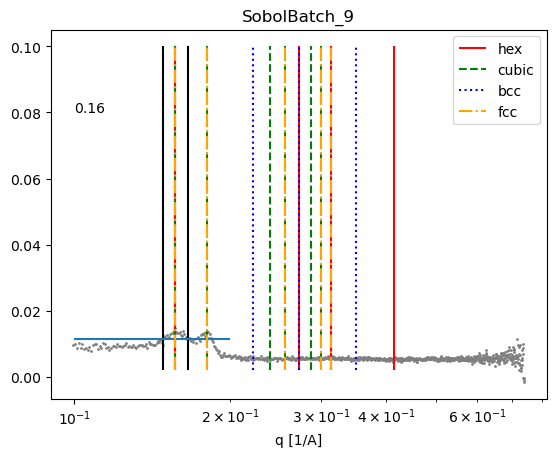

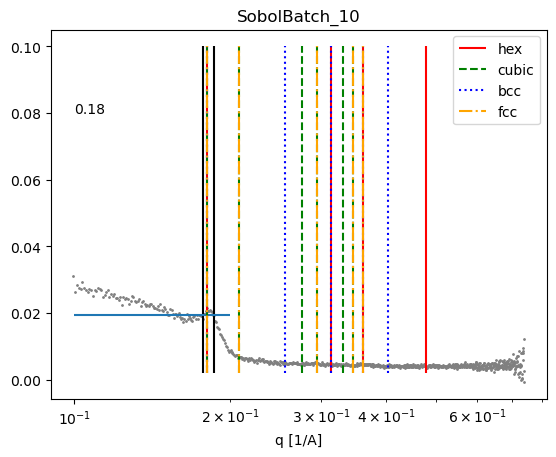

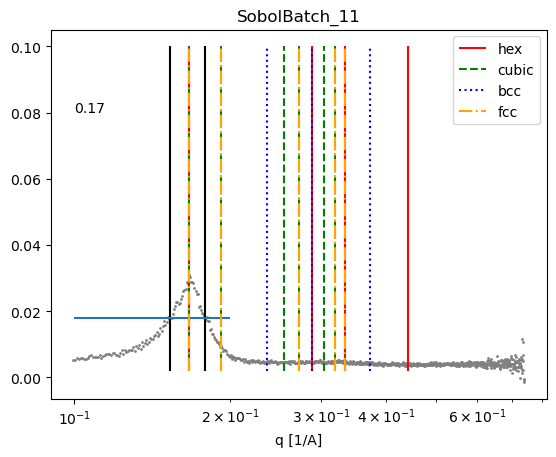

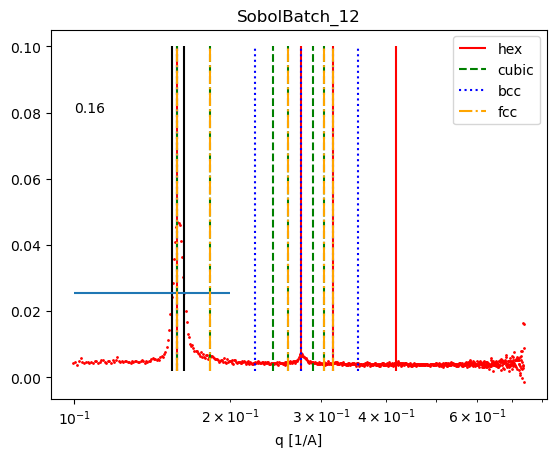

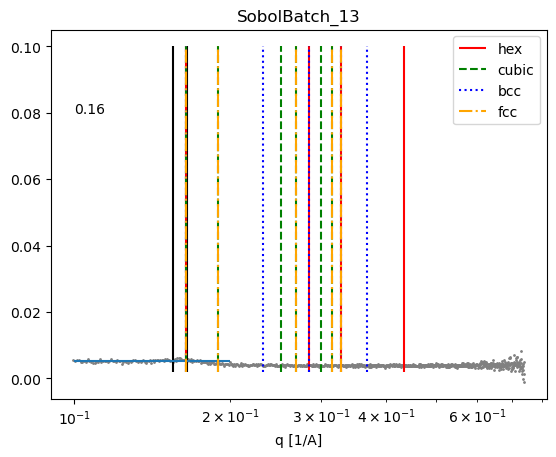

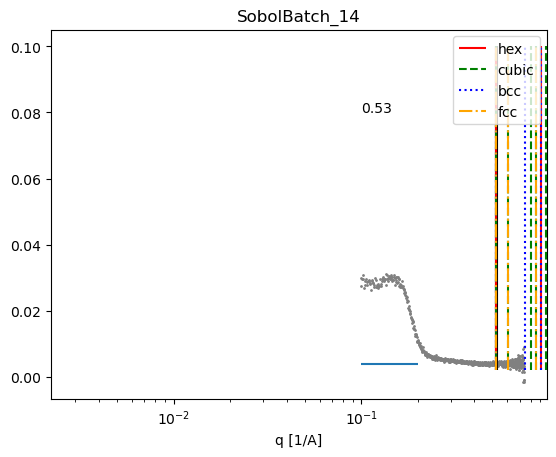

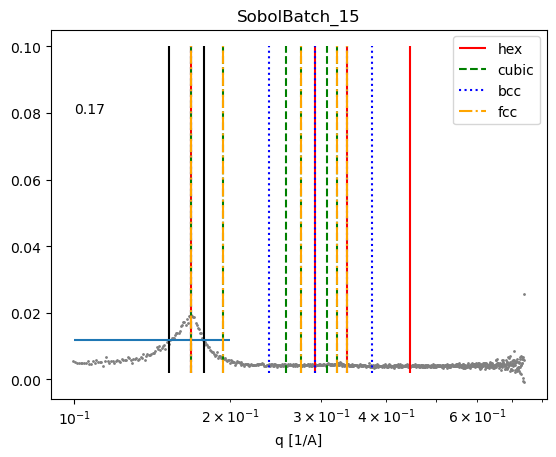

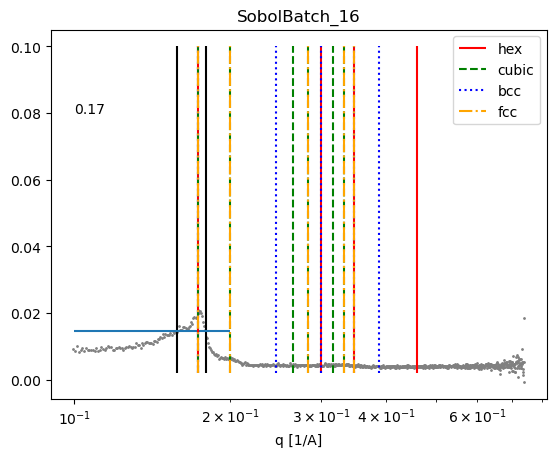

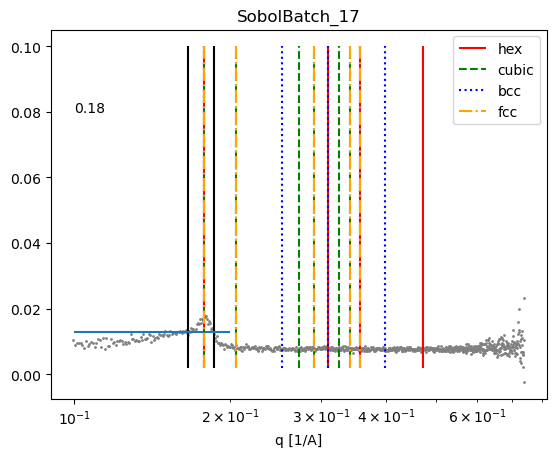

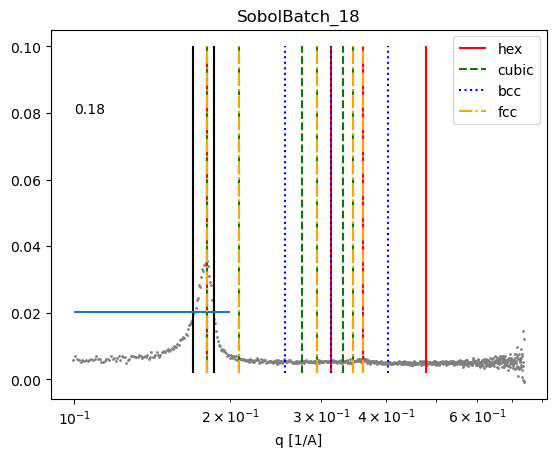

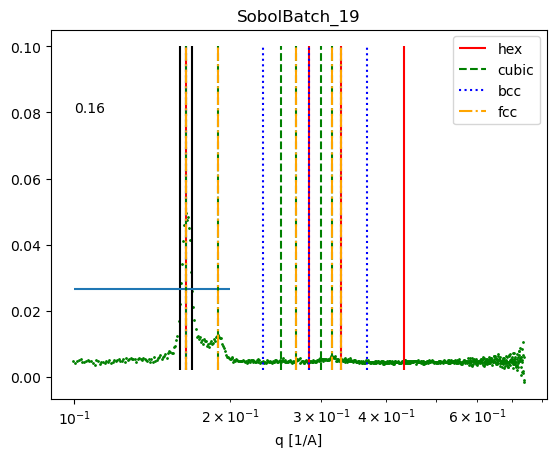

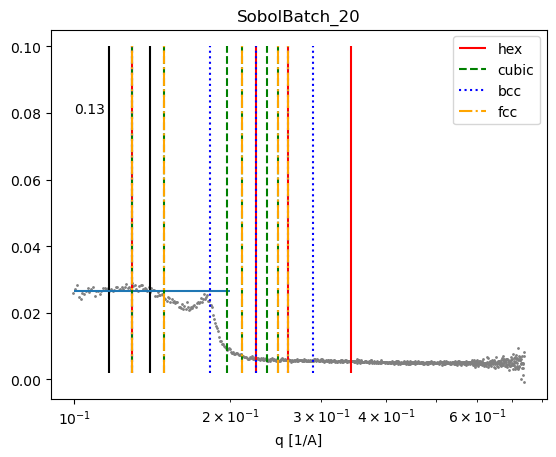

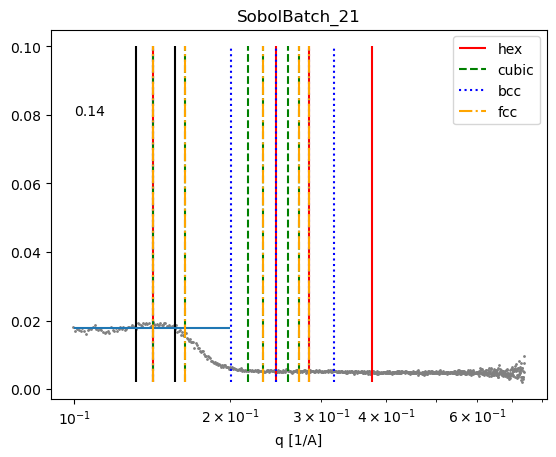

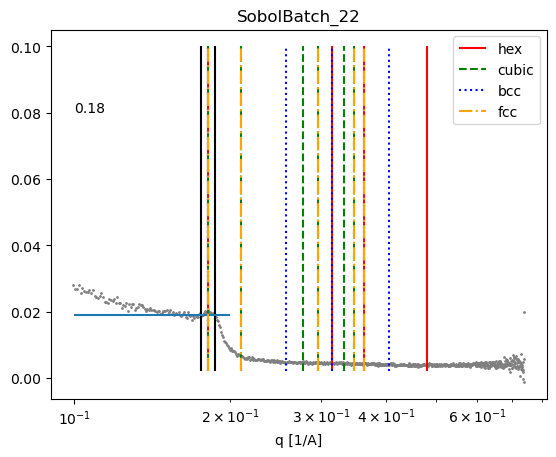

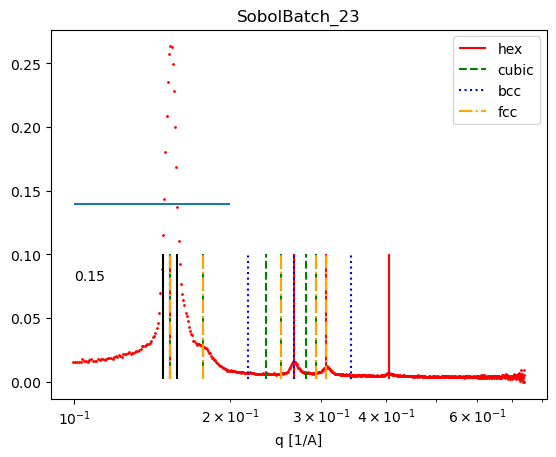

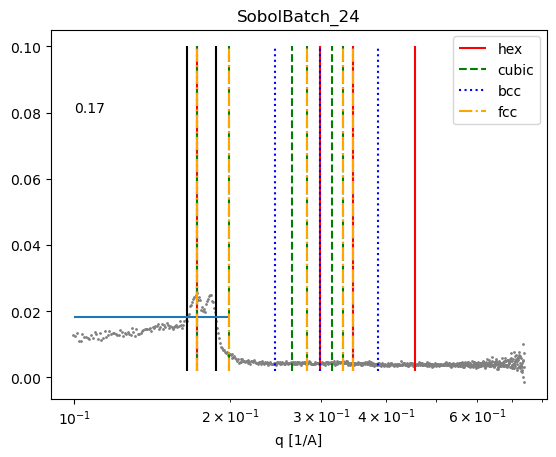

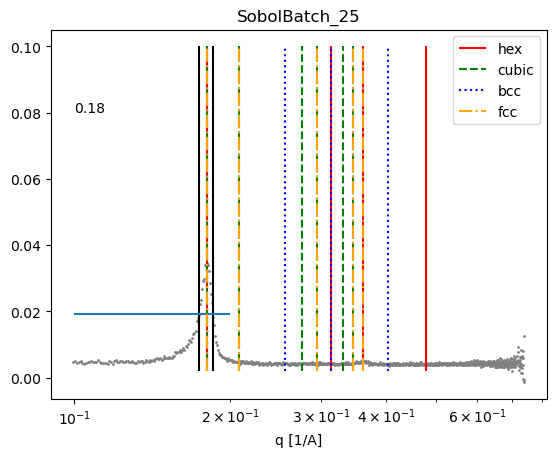

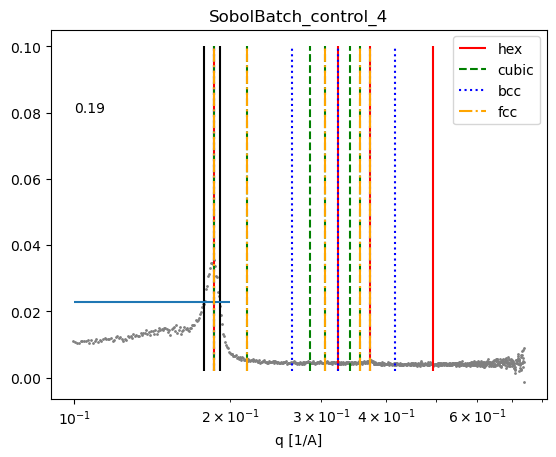

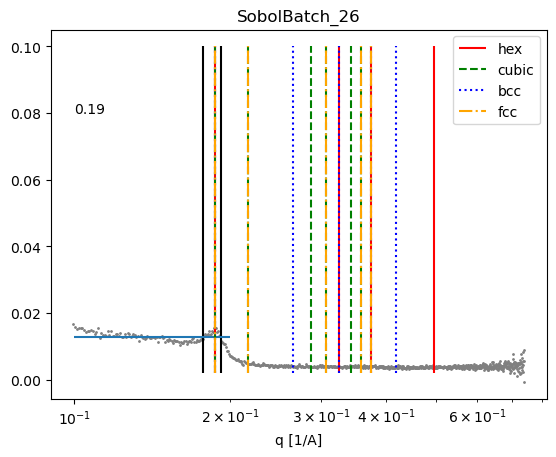

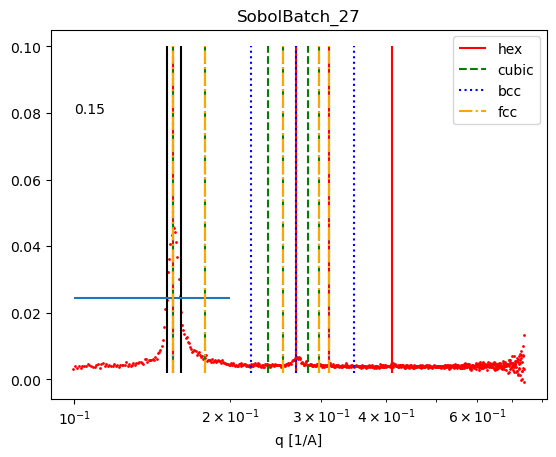

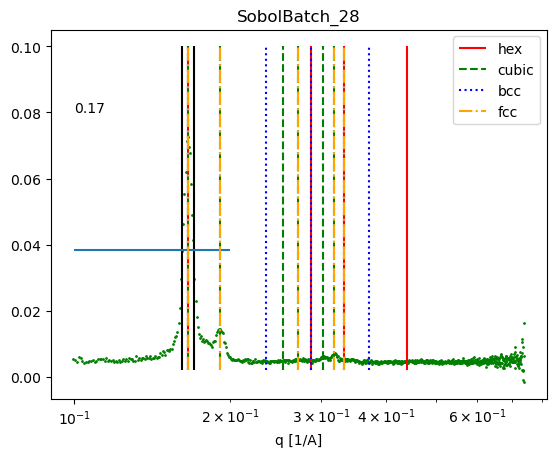

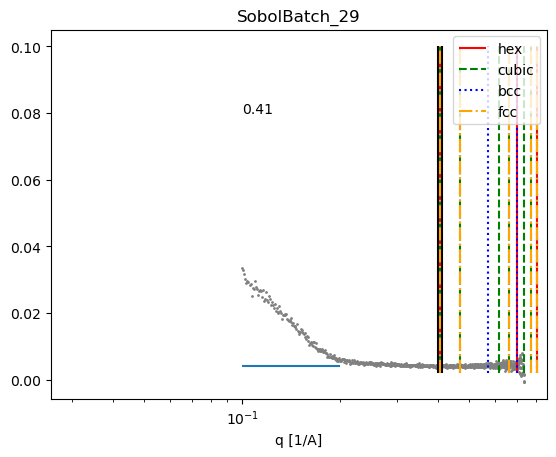

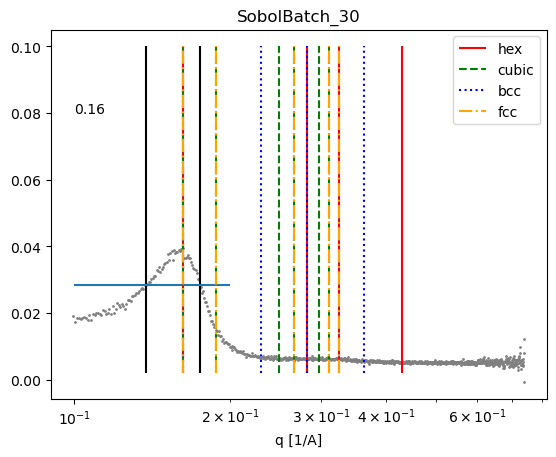

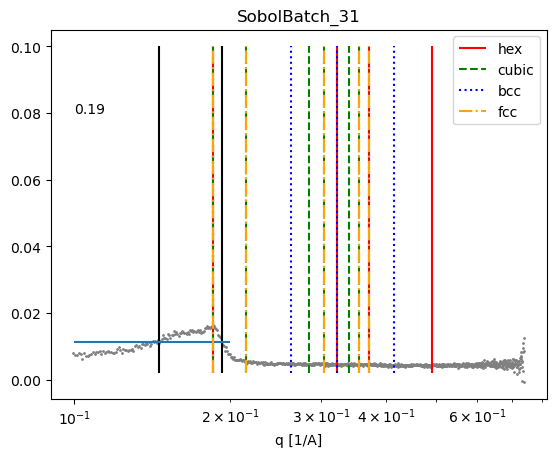

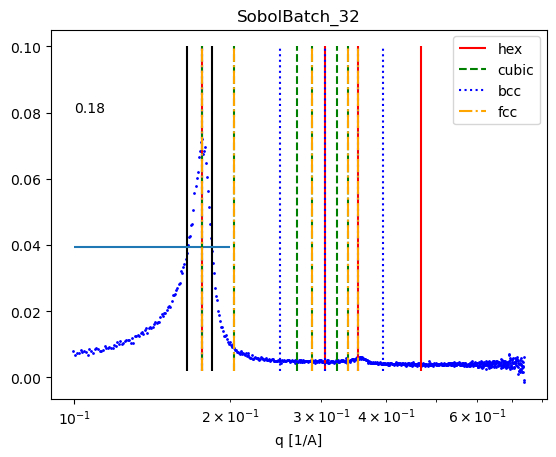

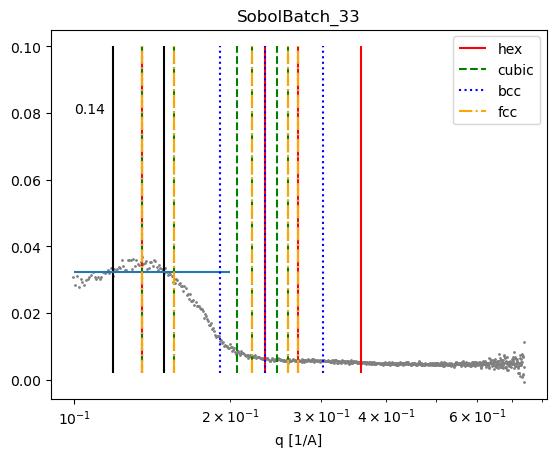

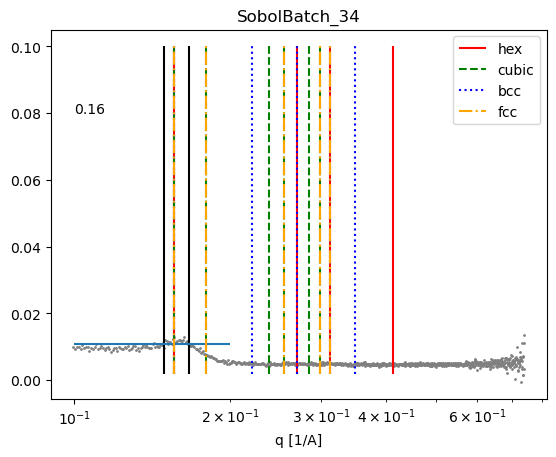

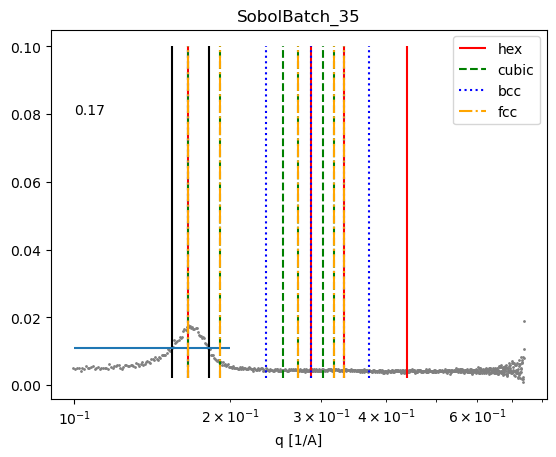

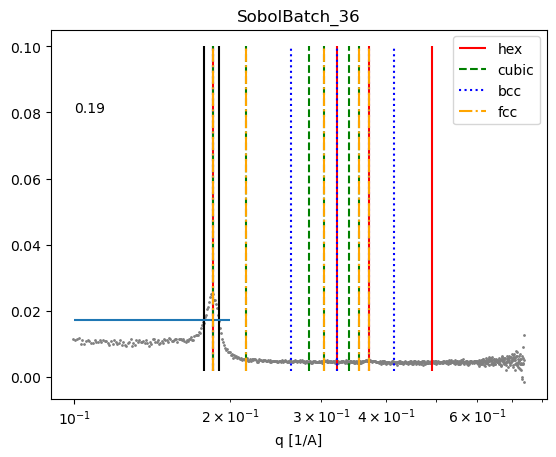

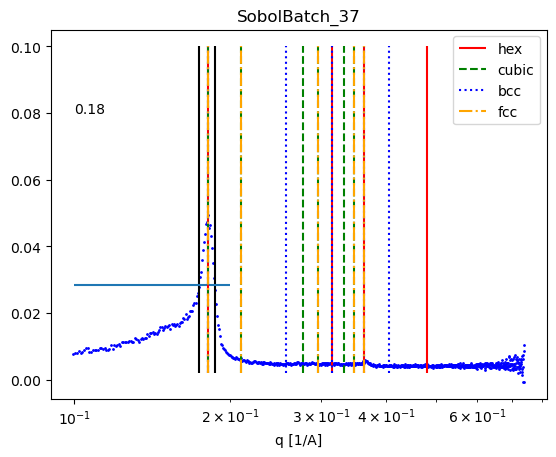

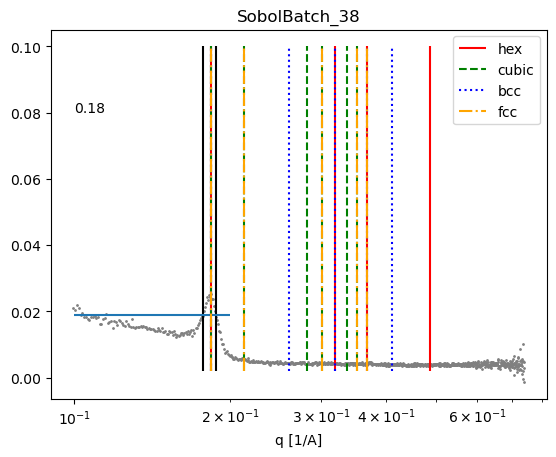

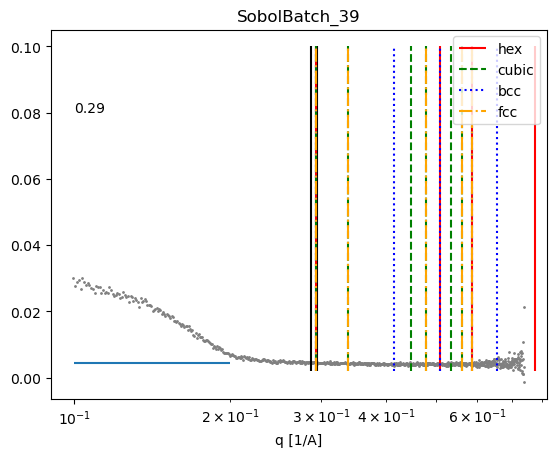

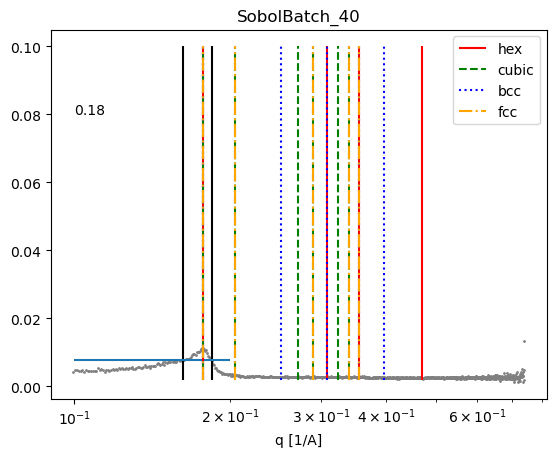

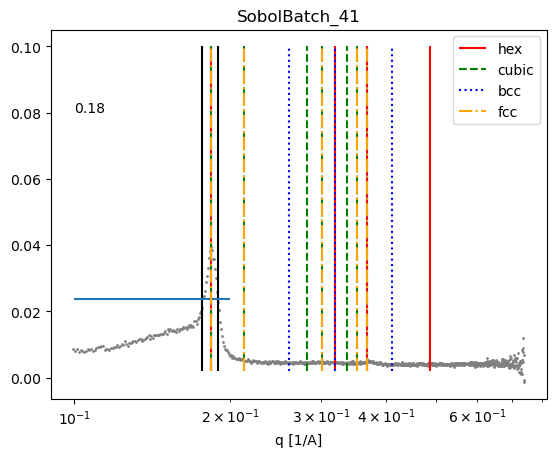

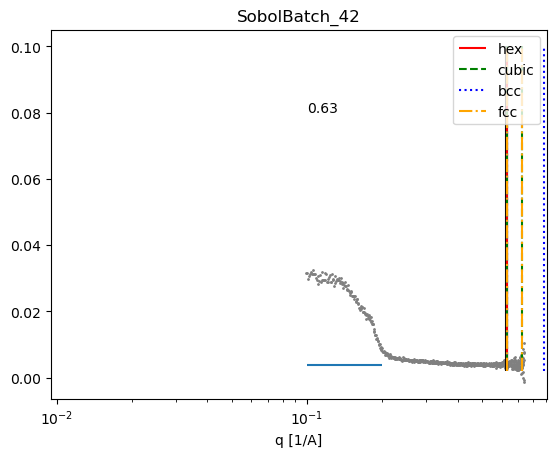

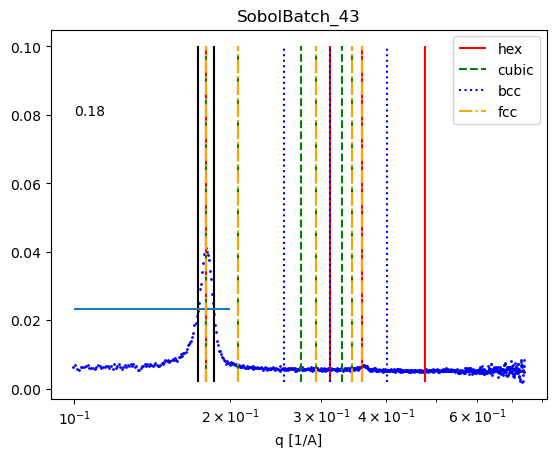

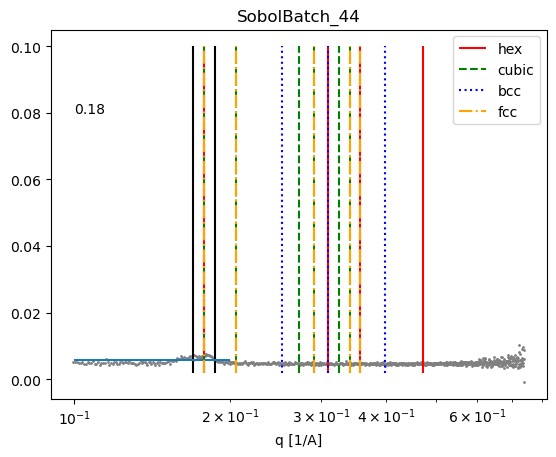

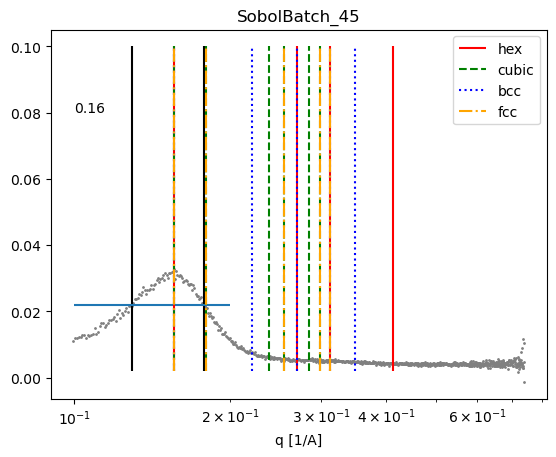

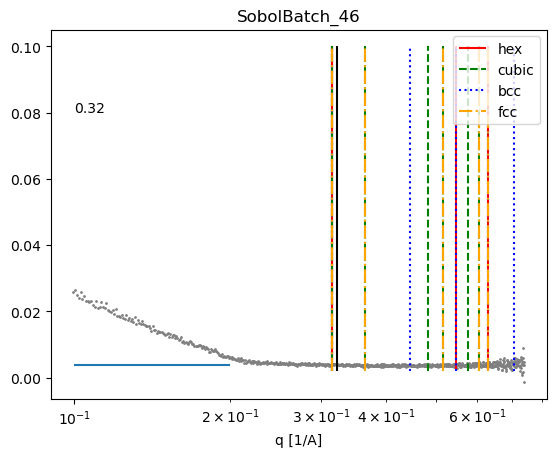

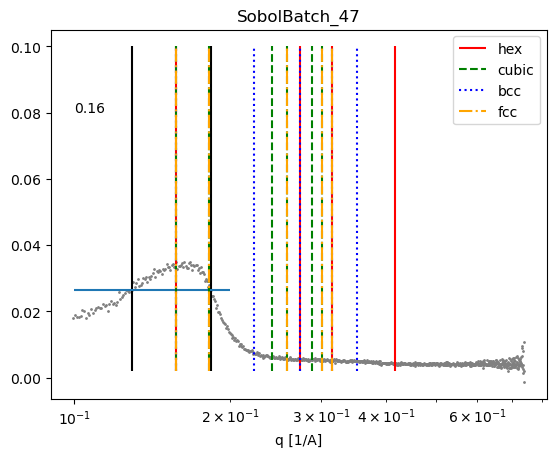

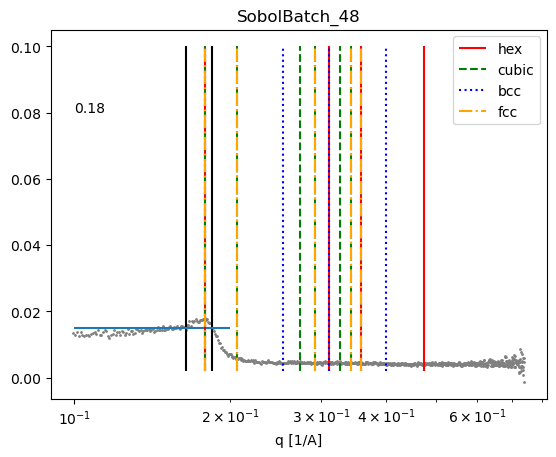

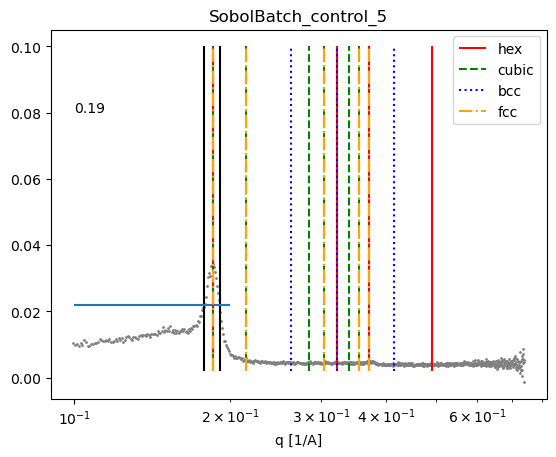

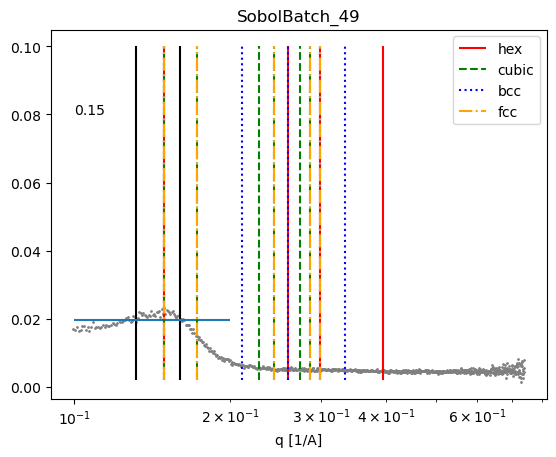

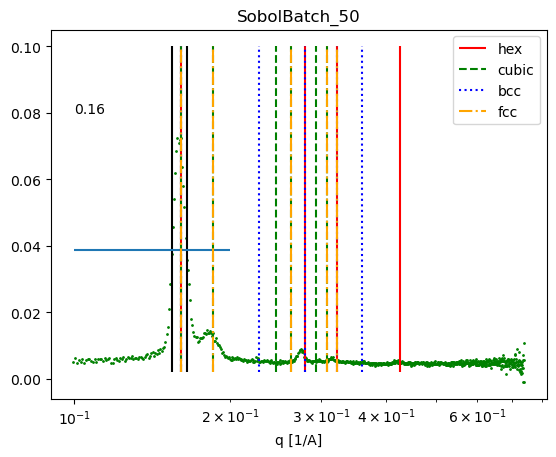

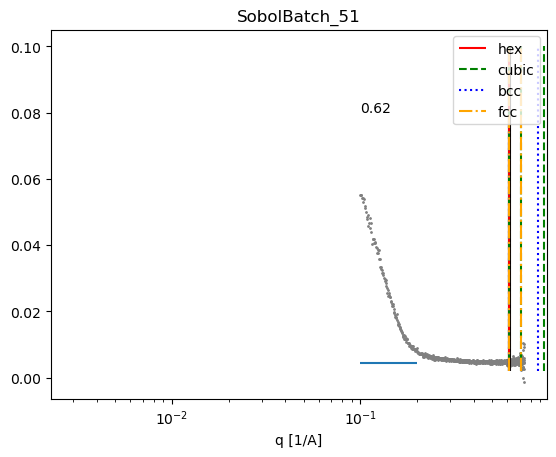

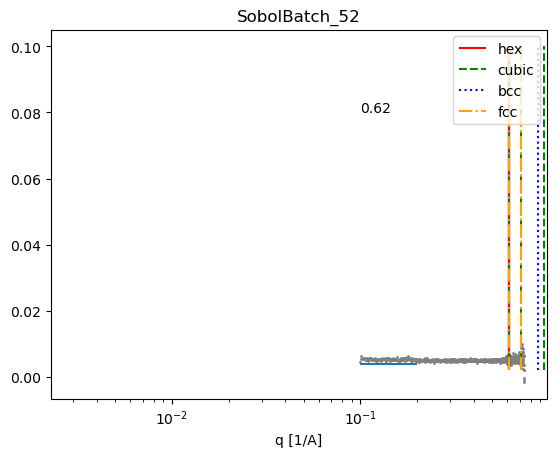

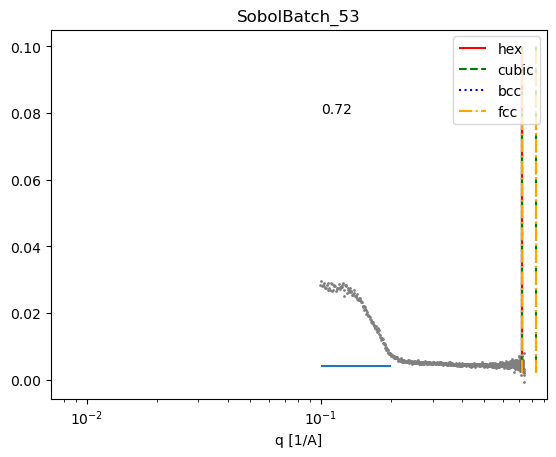

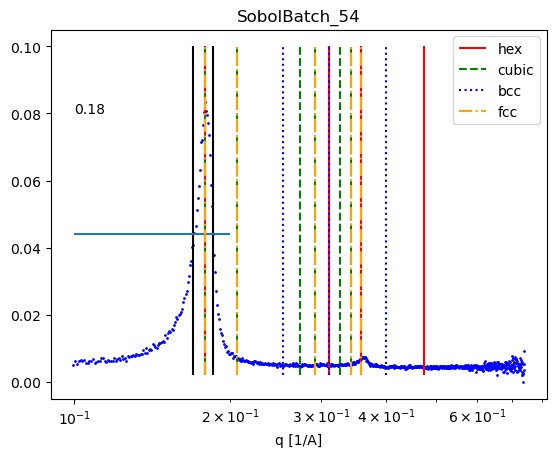

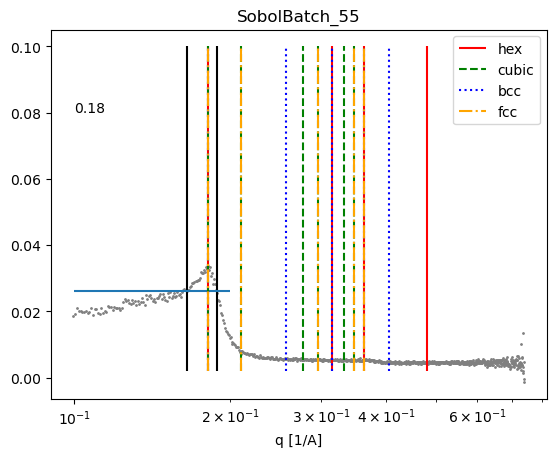

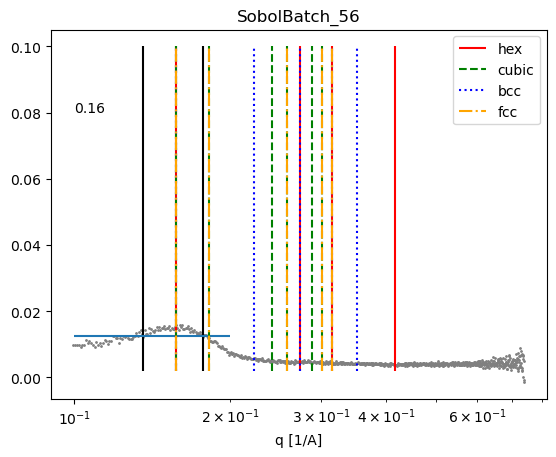

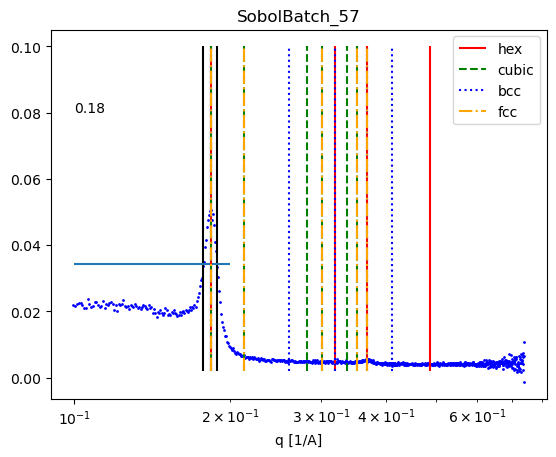

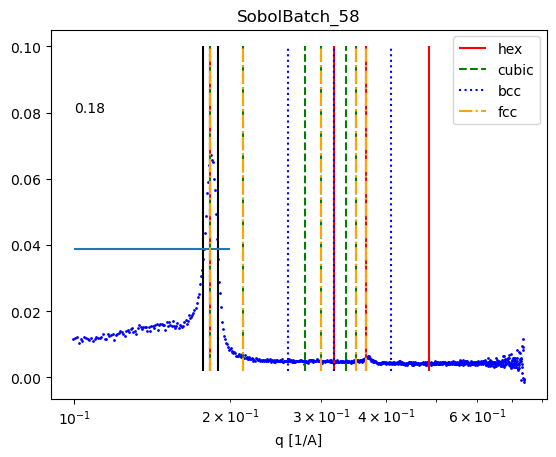

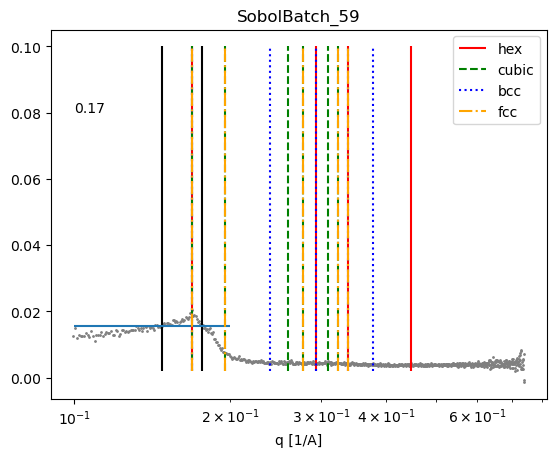

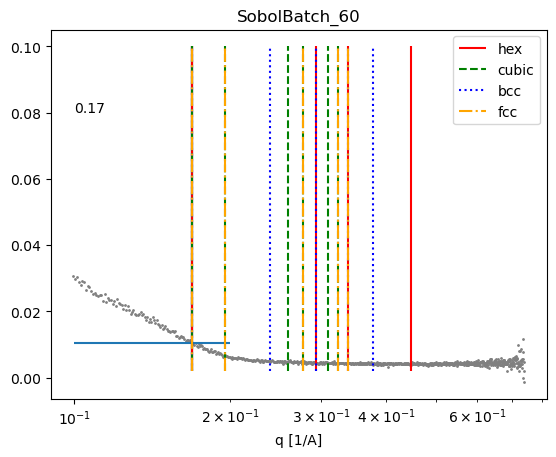

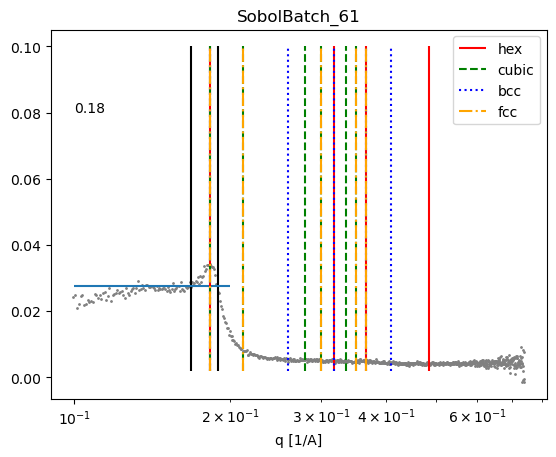

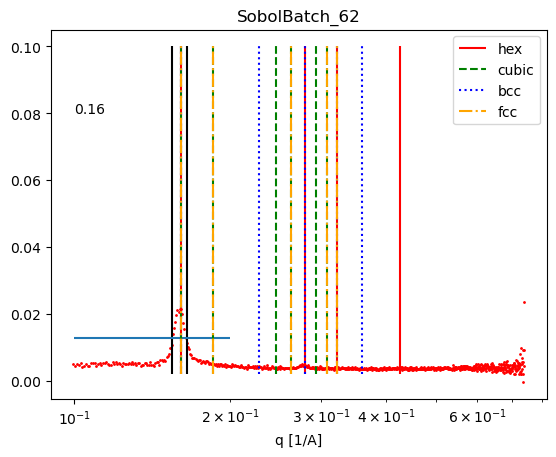

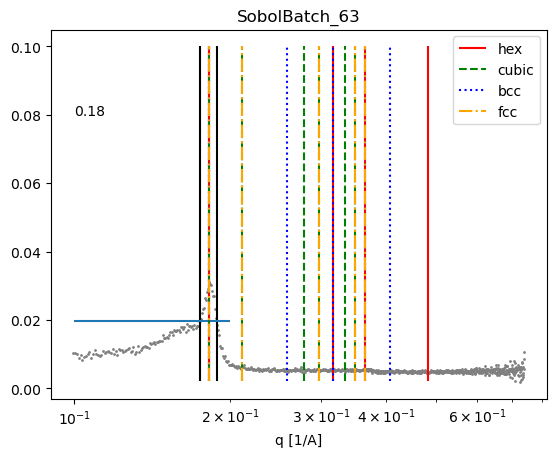

In [45]:
peak_scores = []
hex_pos = []
cubic_pos = []
peak2_pos = []
other_pos = []
for uid, sample in sobolbatch_samples.items():
    #if sample['sample_name'] == 'SobolBatch_43':
    fig, ax = plt.subplots()
    minind = 200
    q = list(sample['data'][0]['q'])[minind:]
    I = list(sample['data'][0]['I'])[minind:]
    try:
        peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]
    except Exception as e:
        print(f'error for sample {sample['sample_name']}, {e}') 
    p0 = q[peak_ind]
    sobolbatch_samples[uid]['peak_position'] = p0
    phase_color = get_phasecolor(p0, phase_break_1, phase_break_2)

    width_vals = peak_widths(I, [peak_ind])
    prom_vals = peak_prominences(I, [peak_ind])

    prominence = prom_vals[0][0]
    print(prom_vals)
    peaks_width = width_vals[0][0]

    ID_phase = phase_table.loc[sample['sample_name']]['Brenden Phase ID']
    print(ID_phase)
    if ID_phase == 'Hex':
        hex_pos.append(p0)
        color = 'red'
    elif ID_phase == 'Cubic':
        cubic_pos.append(p0)
        color = 'green'
    elif ID_phase == 'No ID - 2 peaks':
        peak2_pos.append(p0)
        color = 'blue'
    else:
        other_pos.append(p0)
        color = 'gray'


    width_height = width_vals[1][0]

    
    leftint = int(np.floor(width_vals[2][0]))
    rightint = int(np.ceil(width_vals[3][0]))

    peak_width_q = q[rightint] - q[leftint]
    sharp_score = prominence/peak_width_q
    peak_scores.append(sharp_score)
    sobolbatch_samples[uid]['peak_score'] = sharp_score

    
    hex_peakvals = hex_peaks(p0)
    cubic_peakvals = cubic_peaks(p0)
    bcc_peakvals = bcc_peaks(p0)
    fcc_peakvals = fcc_peaks(p0)
    ax.semilogx(q, I, color = color, ls = '', marker = '.', markersize = 2)

    ax.vlines(q[leftint], 2e-3, 1e-1, color = 'black')
    ax.vlines(q[rightint], 2e-3, 1e-1, color = 'black')
    ax.hlines(width_height, 1e-1, 2e-1)
    for peak in hex_peakvals:
        ax.vlines(peak, 2e-3, 1e-1, color = 'red', label = 'hex')

    for peak in cubic_peakvals:
        ax.vlines(peak, 2e-3, 1e-1, color = 'green', ls = '--', label = 'cubic')

    for peak in bcc_peakvals:
        ax.vlines(peak, 2e-3, 1e-1, color = 'blue', ls = 'dotted', label = 'bcc')

    for peak in fcc_peakvals:
        ax.vlines(peak, 2e-3, 1e-1, color = 'orange', ls = 'dashdot', label = 'fcc')

    #dedupe legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Remove duplicates
    unique = dict(zip(labels, handles))
    
    # Add the legend
    ax.legend(unique.values(), unique.keys())
    ax.text(1e-1, 0.08, f"{p0:.2f}")


    ax.set_xlabel('q [1/A]')
    ax.set_title(sample['sample_name'])
    #plt.savefig('sample43.png', dpi = 300)

In [19]:
np.mean(hex_pos)

/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


np.float64(nan)

In [20]:
np.mean(cubic_pos)

np.float64(nan)

In [21]:
np.mean(peak2_pos)

np.float64(nan)

## Group based on first peak position instead of peak indexes

In [22]:
phase_break_1 = 0.17
phase_break_2 = 0.2

peaks_widths = []
peak_pos = []

for uid, sample in sobolbatch_samples.items():
    #if sample['sample_name'] == 'SobolBatch_43':
    #fig, ax = plt.subplots()
    minind = 200
    q = list(sample['data'][0]['q'])[minind:]
    I = list(sample['data'][0]['I'])[minind:]
    try:
        peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]
    except Exception as e:
        print(f'error for sample {sample['sample_name']}, {e}') 
    p0 = q[peak_ind]

    width = peak_widths(I, [peak_ind])

    print(width)
    peaks_widths.append(width[0][0])
    #sobolbatch_samples[uid]['phase_color'] = get_phasecolor(p0, phase_break_1, phase_break_2)

    
    

(array([16.06223966]), array([0.02146776]), array([94.26238739]), array([110.32462706]))
(array([15.61581738]), array([0.02192472]), array([94.41390249]), array([110.02971988]))
(array([12.50626131]), array([0.02350692]), array([94.86351191]), array([107.36977322]))
(array([15.17443654]), array([0.04152159]), array([92.76540335]), array([107.93983988]))
(array([11.84911034]), array([0.01598871]), array([99.6981317]), array([111.54724204]))
(array([12.98111661]), array([0.01140705]), array([91.6329627]), array([104.61407931]))
(array([11.67988366]), array([0.03445764]), array([60.00094287]), array([71.68082652]))
(array([11.62847174]), array([0.0076088]), array([70.14091029]), array([81.76938203]))
(array([34.15389554]), array([0.01743217]), array([77.45157824]), array([111.60547378]))
(array([17.14272068]), array([0.04534538]), array([92.33755413]), array([109.48027481]))
(array([20.25318395]), array([0.01133133]), array([59.61698345]), array([79.87016741]))
(array([9.45144232]), array

/tmp/ipykernel_1959/970623843.py:14: RuntimeWarning: invalid value encountered in log10
  peak_ind = find_peaks(np.log10(I), prominence=0.01, width=10)[0][0]
/tmp/ipykernel_1959/970623843.py:19: PeakPropertyWarning: some peaks have a prominence of 0
  width = peak_widths(I, [peak_ind])
/tmp/ipykernel_1959/970623843.py:19: PeakPropertyWarning: some peaks have a width of 0
  width = peak_widths(I, [peak_ind])


Text(0.5, 0, 'First peak q pos [1/A]')

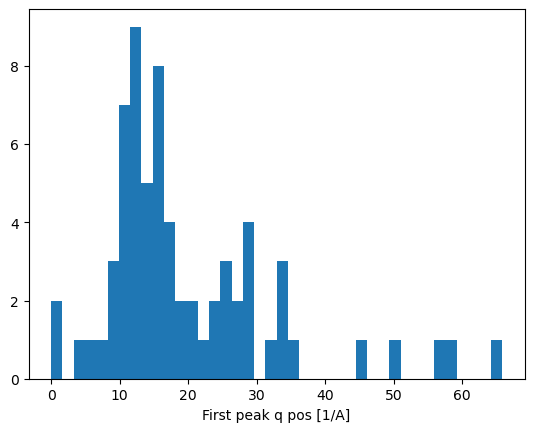

In [23]:
plt.hist(peaks_widths, bins=40)
plt.xlabel('First peak q pos [1/A]')


In [24]:
sobolbatch_samples["a8e7d7a2-13f6-4bbf-8106-048dc5a40ec7"]['peak_position']

KeyError: 'peak_position'

## Make phase plots

In [25]:
ctab_min_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000
ctab_max_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000

In [26]:
f127_min_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/10000
f127_max_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/10000

In [27]:
lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass'],
                constants['f127']['minimum_mass'],
                constants['water']['minimum_volume_fraction']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass'],
                constants['f127']['maximum_mass'],
                constants['water']['maximum_volume_fraction']]

In [28]:
def get_phase_color_manual(phase):

    if 'No ID - 2 peaks' in phase:
        return 'blue'
    if 'No peak' in phase:
        return 'gray'
    if phase == 'Peak':
        return 'orange'
    if phase == 'Cubic':
        return 'green'
    if phase == 'Hex':
        return 'red'
    print('no phase found, phase name', phase)

In [29]:
from matplotlib.ticker import FuncFormatter
def format_func_0(x, _):
    return f'{x:.2f}'

def format_func(x, _):
    return f'{x:.2f}'

In [30]:
format_func(300.00, 1)

'300.00'

/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<function plot_phasemap.<locals>.<lambda> at 0x7efcdc25ed40>
<function plot_phasemap.<locals>.<lambda> at 0x7efce07e1080>


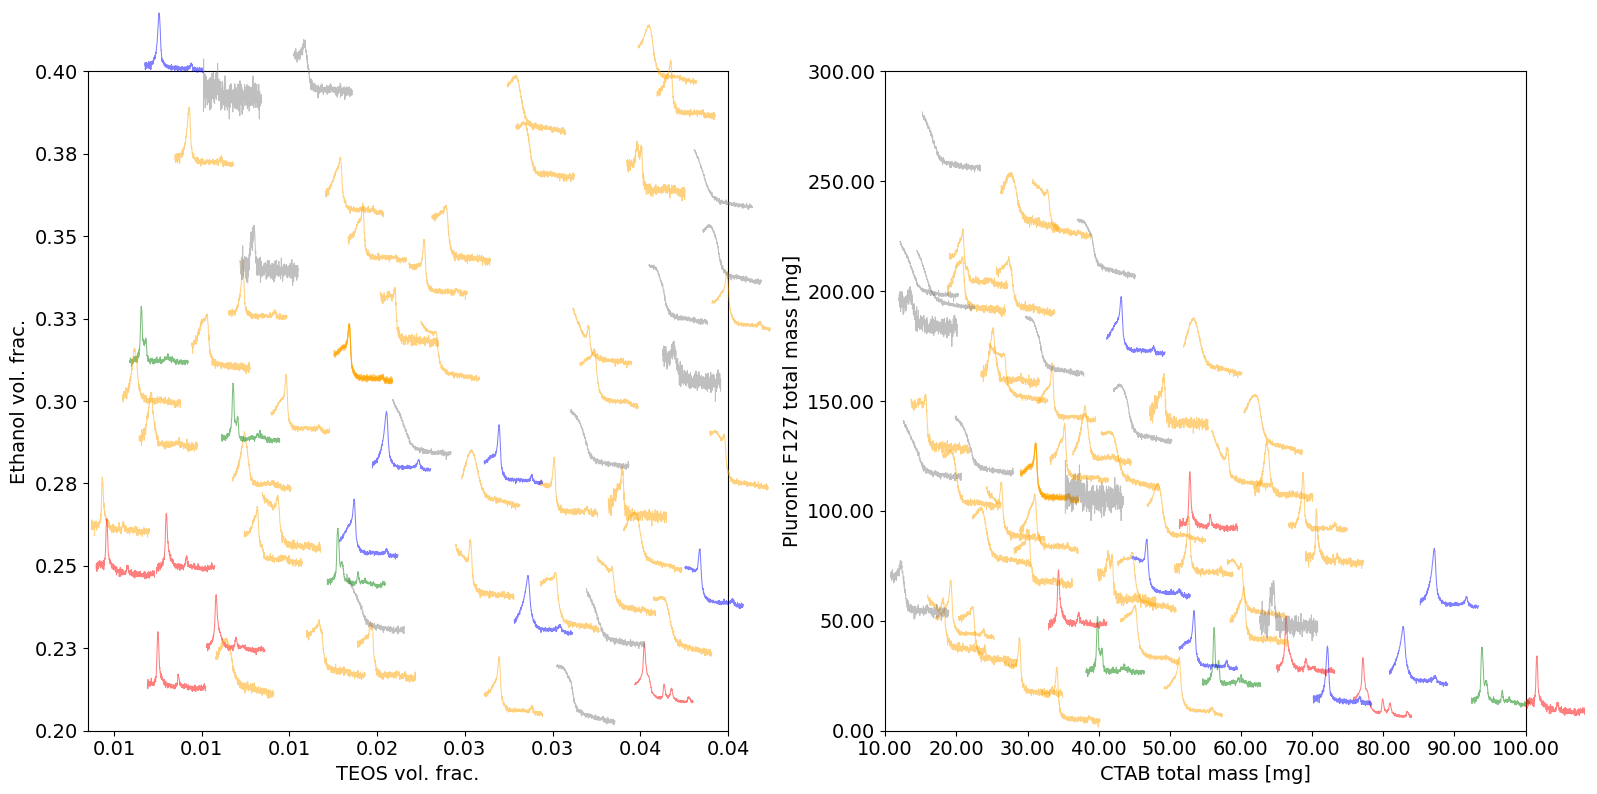

In [47]:
x_ind = 0
y_ind = 2

x_2_ind = 3
y_2_ind = 4


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']
labels = ['TEOS vol. frac.', 'Ammonium Hyrdroxide vol. frac.', 'Ethanol vol. frac.', 'CTAB total mass [mg]', 'Pluronic F127 total mass [mg]', 'Water vol. frac.']

x_name = names[x_ind]
y_name = names[y_ind]

x_2_name = names[x_2_ind]
y_2_name = names[y_2_ind]

x_min = lower_bounds[x_ind]
x_max = upper_bounds[x_ind]
y_min = lower_bounds[y_ind]
y_max = upper_bounds[y_ind]

x_2_min = lower_bounds[x_2_ind]
x_2_max = upper_bounds[x_2_ind]
y_2_min = lower_bounds[y_2_ind]
y_2_max = upper_bounds[y_2_ind]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_2_min, y_2_min], [x_2_max, y_2_max]])

x_key = x_name
y_key = y_name

x_2_key = x_2_name
y_2_key = y_2_name

fig, ax = plt.subplots(1, 2, figsize = (16, 8))



c_1 = []
s = []
c_2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in sobolbatch_samples.items():

    x_val = sample['composition'][x_key]
    y_val = sample['composition'][y_key]


    x_2_val = sample['composition'][x_2_key]
    y_2_val = sample['composition'][y_2_key]

    I = np.array(np.log10(sample['data'][0]['I']))[200:600]


    c_1.append([x_val, y_val])
    s.append(I)
    c_2.append([x_2_val, y_2_val])
    
    ID_phase = phase_table.loc[sample['sample_name']]['Brenden Phase ID']
    #print(phase)
    color = get_phase_color_manual(ID_phase)
    colors_1.append(color)
    #c_2.append([x_val, y_2_val])
    #colors_1.append(get_colormap_color(y_2_val, y_2_min, y_2_max))
    #colors_2.append(get_colormap_color(y_val, y_min, y_max))

        

s = np.array(s)


pd_utils.plot_phasemap(bounds, ax[0], c_1, s, colors = colors_1)
pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s, colors = colors_1)


ax[0].set_xlabel(f'{labels[x_ind]}', size = 14)
ax[0].set_ylabel(f'{labels[y_ind]}', size = 14)

ax[0].yaxis.set_major_formatter(FuncFormatter(format_func_0))
ax[0].xaxis.set_major_formatter(FuncFormatter(format_func_0))

ax[0].set_xlim([bounds[0][0], bounds[1][0]])
ax[0].set_ylim([bounds[0][1], bounds[1][1]])


ax[1].set_xlabel(f'{labels[x_2_ind]}', size = 14)
ax[1].set_ylabel(f'{labels[y_2_ind]}', size = 14)

ax[1].yaxis.set_major_formatter(FuncFormatter(format_func))
ax[1].xaxis.set_major_formatter(FuncFormatter(format_func))

ax[1].set_xlim([bounds_2[0][0], bounds_2[1][0]])
ax[1].set_ylim([bounds_2[0][1], bounds_2[1][1]])

ax[0].tick_params(axis='both', labelsize=14) 
ax[1].tick_params(axis='both', labelsize=14) 


plt.tight_layout()
plt.savefig(f'Phaseplot_saxs_TEOSEthanolSurfactant.png', dpi = 300)


In [33]:
phase_table.loc[1]

Sample name         Empty cell blank
Brenden Phase ID                   -
Unnamed: 2                       NaN
Name: 1, dtype: object

In [40]:
bounds_2[0]


array([0.0035, 0.3   ])

## SHAP on peak position, peak sharpness

In [31]:
teos_vf = []
ammonia_vf = []
ethanol_vf = []
ctab_mass = []
f127_mass = []
water_vf = []

peak_pos_cutoff = 0.2
peak_score_cutoff = 10

peak_positions = []
peak_score = []
for uid, sample in sobolbatch_samples.items():
    teos_vf.append(sample['composition']['teos_vf'])
    ammonia_vf.append(sample['composition']['ammonia_vf'])
    ethanol_vf.append(sample['composition']['ethanol_vf'])
    ctab_mass.append(sample['composition']['ctab_mass'])
    f127_mass.append(sample['composition']['F127_mass'])
    water_vf.append(sample['composition']['water_vf'])
    peak_pos = sample['peak_position']
    if peak_pos < peak_pos_cutoff:
        peak_positions.append(peak_pos)
    else:
        peak_positions.append(np.nan)

    peak_score_val = sample['peak_score']
    if peak_score_val < peak_score_cutoff:
        peak_score.append(sample['peak_score'])
    else:
        peak_score.append(np.nan)
    
    
    

(array([ 2.,  0.,  1.,  1.,  8.,  5.,  8.,  2., 11., 21.]),
 array([0.129271 , 0.1350531, 0.1408352, 0.1466173, 0.1523994, 0.1581815,
        0.1639636, 0.1697457, 0.1755278, 0.1813099, 0.187092 ]),
 <BarContainer object of 10 artists>)

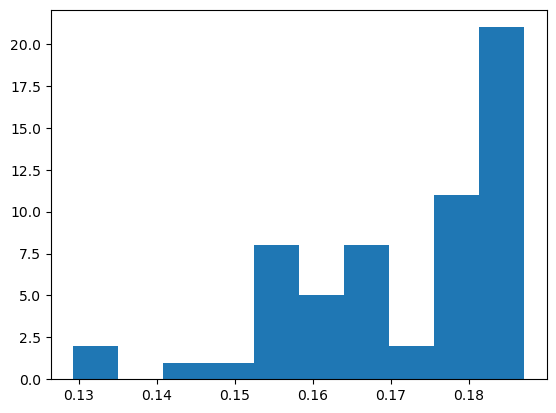

In [32]:
plt.hist(peak_positions)

In [33]:
x = np.column_stack((teos_vf, ammonia_vf, ethanol_vf, ctab_mass, f127_mass, water_vf))

In [34]:
x.shape

(67, 6)

In [35]:
scaler_x = MinMaxScaler()
scaler_positions = MinMaxScaler()
scaler_score = MinMaxScaler()

In [36]:
x_scaled_full = scaler_x.fit_transform(x)
positions_scaled = scaler_positions.fit_transform(np.array(peak_positions).reshape(-1,1))
scores_scaled = scaler_score.fit_transform(np.array(peak_score).reshape(-1,1))

In [37]:
rand_state = 12

In [38]:
position_mask = ~ np.isnan(positions_scaled)

x_scaled_full = x_scaled_full[position_mask.reshape(-1), :]
positions_scaled = positions_scaled[position_mask]
scores_scaled = scores_scaled[position_mask]

score_mask = ~np.isnan(scores_scaled)

x_scaled_full = x_scaled_full[score_mask.reshape(-1), :]
positions_scaled = positions_scaled[score_mask]
scores_scaled = scores_scaled[score_mask]

In [39]:
x_train, x_test, pos_train, pos_test = train_test_split(x_scaled_full, positions_scaled, train_size = 0.8, random_state=rand_state)
x_train, x_test, score_train, score_test = train_test_split(x_scaled_full, scores_scaled, train_size = 0.8, random_state=rand_state)

In [40]:
regressor_pos = xgboost.XGBRegressor()

In [41]:
regressor_pos.fit(x_scaled_full, positions_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
x_scaled = pd.DataFrame(x_scaled_full, columns = ['TEOS vol. frac.', 'Ammonia vol. frac.', 'Ethanol vol. frac.', 'CTAB mass', 'F127 mass', 'Water vol. frac.'])

  0%|          | 0/57 [00:00<?, ?it/s]

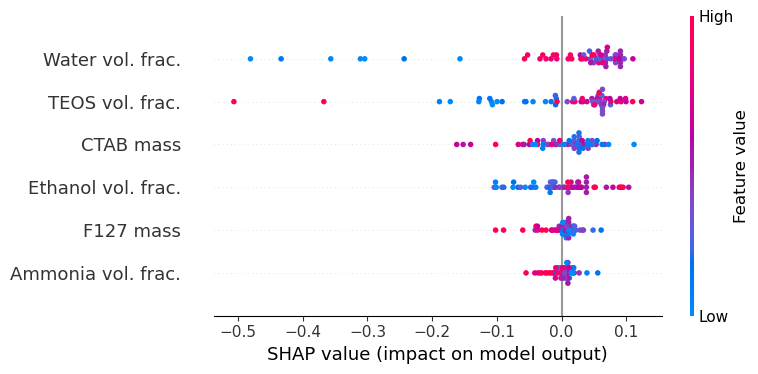

In [43]:
plt.rcParams.update({'font.size': 12})

# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_pos.predict, x_scaled)
shap_values = explainer.shap_values(x_scaled)
shap.summary_plot(shap_values, x_scaled, show=False)
ax.set_xlabel("Impact on position", fontsize=14)
#plt.savefig('shap_diam.png', dpi = 300)
plt.show()

In [45]:
regressor_score = xgboost.XGBRegressor()

In [46]:
regressor_score.fit(x_scaled_full, scores_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

  0%|          | 0/57 [00:00<?, ?it/s]

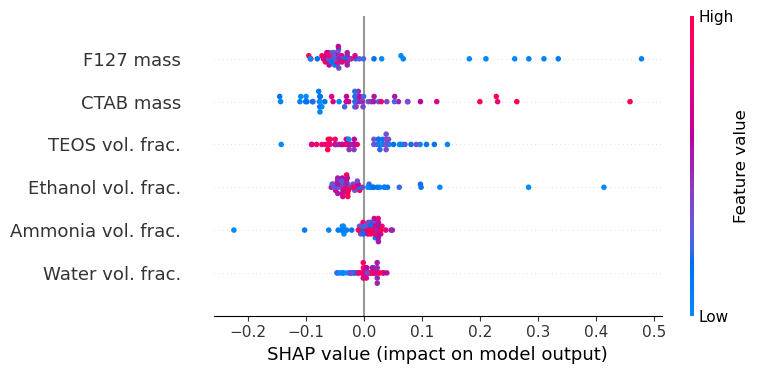

In [110]:
plt.rcParams.update({'font.size': 12})

# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_score.predict, x_scaled)
shap_values = explainer.shap_values(x_scaled)
shap.summary_plot(shap_values, x_scaled, show=False)
ax.set_xlabel("Impact on sharpness", fontsize=14)
plt.savefig('shap_sharpness.png', dpi = 300)
plt.show()

## star plots

In [73]:
for tic in ax.get_xticklabels():
    print(tic)

Text(0.0, 0, '10.000')
Text(0.2, 0, '28.000')
Text(0.4, 0, '46.000')
Text(0.6000000000000001, 0, '64.000')
Text(0.8, 0, '82.000')
Text(1.0, 0, '100.000')


In [28]:
import pandas as pd
import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
seed = np.random.RandomState(seed=2050)
import itertools as it 
import matplotlib.pyplot as plt
# from matplotlib.colormaps import get_cmap
from matplotlib import cm
from matplotlib.colors import Normalize

In [29]:
def reduce(grid):
    similarities = euclidean_distances(grid)

    dim = 2
    max_iter = 6000
    eps = 1e-9
    mds = manifold.MDS(n_components=dim, 
                       max_iter=max_iter, 
                       eps=eps, 
                       random_state=seed,
                       dissimilarity='precomputed'
                       )
    print('Similarities have shape {}'.format(np.shape(similarities)))
    mds.fit(similarities)
    pos = mds.embedding_

    return pos

In [30]:
n = 10
inary = 5
el = np.array([i/n for i in range(n+1)])
grid = np.array([x for x in it.product(el, repeat=inary) if np.isclose(np.sum(x),1)])
corners = np.eye(inary)
pos_grid = reduce(grid)


Similarities have shape (1001, 1001)


In [31]:


from scipy.spatial.distance import cdist

def look_up_grid(x):
    dist = cdist(x.reshape(1,-1), grid)
    idx = np.argmin(dist)

    return pos_grid[idx,:]

corners = np.eye(inary)
pos_corners = np.asarray([look_up_grid(ci) for ci in corners])
pos_zero = look_up_grid(np.zeros(inary))



In [32]:
pos_zero

array([9.33544652e-05, 1.16772021e-03])

In [33]:
pos_corners

array([[-0.67801108, -0.60755204],
       [ 0.20162848,  0.8889203 ],
       [-0.79131574,  0.45133631],
       [ 0.3354758 , -0.84621714],
       [ 0.9098995 ,  0.04965776]])

## normalize composition data into range 0, 1

Leave out water for now

In [78]:
x = np.zeros((len(sobolbatch_samples), 5))

for i, sample in enumerate(sobolbatch_samples.values()):
    teos_norm = (sample['composition']['teos_vf'] - lower_bounds[0])/(upper_bounds[0] - lower_bounds[0])
    ammonia_norm = (sample['composition']['ammonia_vf'] - lower_bounds[1])/(upper_bounds[1] - lower_bounds[1])
    ethanol_norm = (sample['composition']['ethanol_vf'] - lower_bounds[2])/(upper_bounds[2] - lower_bounds[2])
    ctab_norm = (sample['composition']['ctab_mass'] - lower_bounds[3])/(upper_bounds[3] - lower_bounds[3])
    f127_norm = (sample['composition']['F127_mass'] - lower_bounds[4])/(upper_bounds[4] - lower_bounds[4])

    x[i,:] = [teos_norm, ammonia_norm, ethanol_norm, ctab_norm, f127_norm]

In [79]:
pos_data = np.asarray([look_up_grid(x[i,:]) for i in range(len(x))]) 

In [80]:
x_min = min(pos_data[:,0])
y_min = min(pos_data[:,1])

x_max = max(pos_data[:,0])
y_max = max(pos_data[:,1])

<function plot_phasemap.<locals>.<lambda> at 0x7f5d1764a8e0>


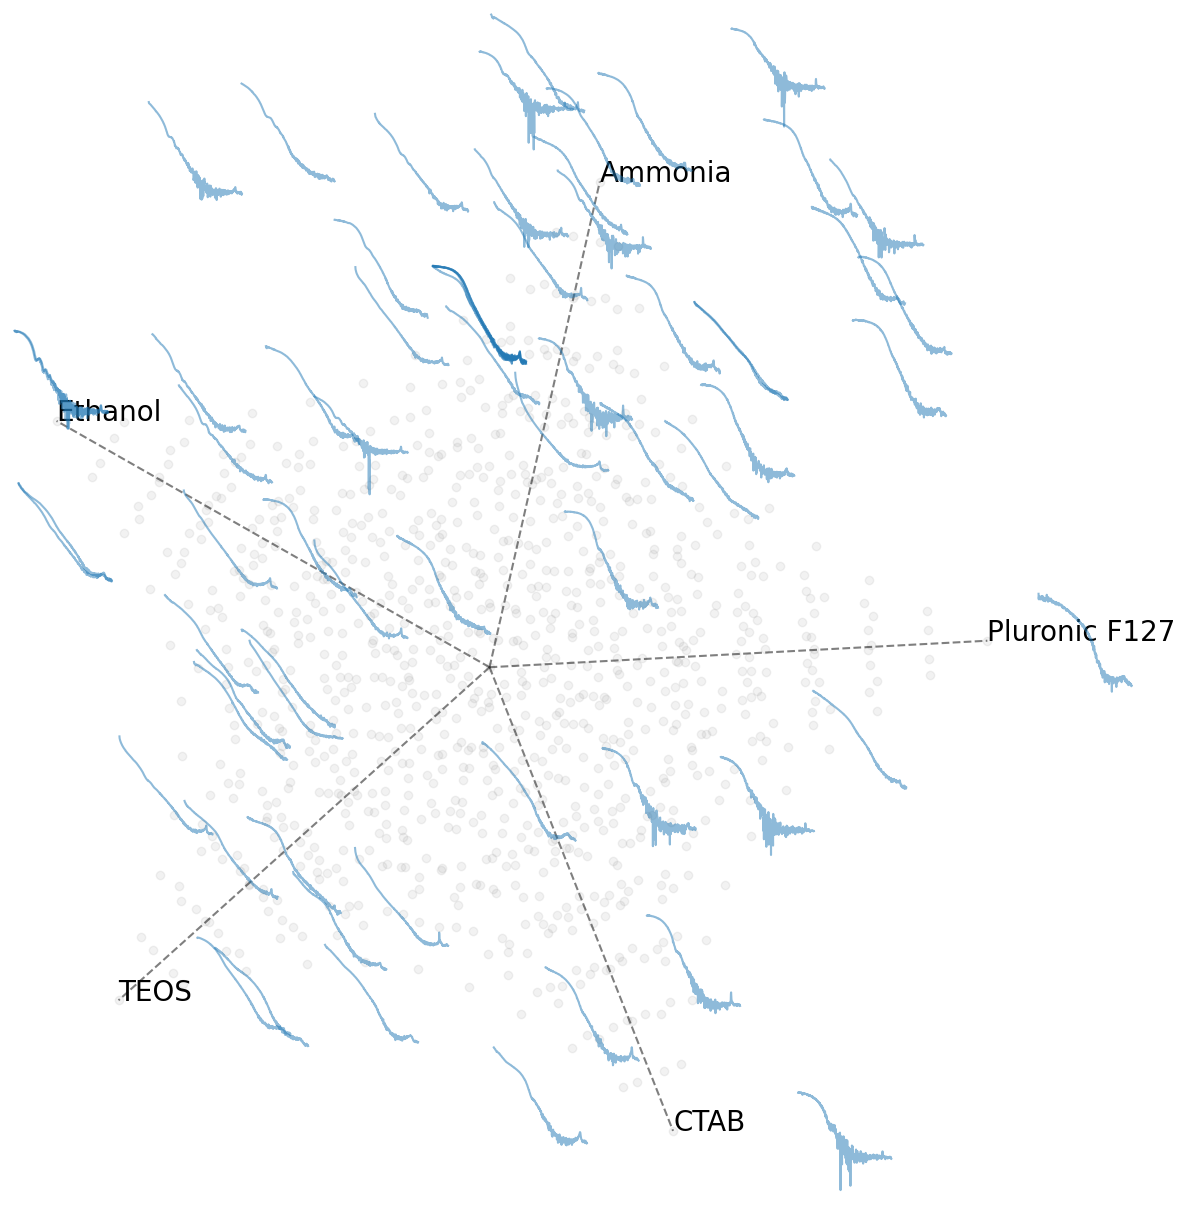

In [82]:
x_ind = 0
y_ind = 3


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']

# x_name = names[x_ind]
# y_name = names[y_ind]

# x_min = lower_bounds[x_ind]
# x_max = upper_bounds[x_ind]
# y_min = lower_bounds[y_ind]
# y_max = upper_bounds[y_ind]

# y_2_min = lower_bounds[1]
# y_2_max = upper_bounds[1]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
#bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])




fig, ax = plt.subplots(figsize = (12, 12))

c_1 = []
s = []
#c_2 = []

colors_1 = []
colors_2 = []
for i, (uuid_val, sample) in enumerate(sobolbatch_samples.items()):


    I = np.log10(sample['data']['Intensity'])
    s.append(I)

        

s = np.array(s)
c_1 = pos_data

pd_utils.plot_phasemap(bounds, ax, c_1, s)

axis_names = np.asarray(['TEOS', 'Ammonia', 'Ethanol', 'CTAB', 'Pluronic F127'])
for i, l in enumerate(axis_names):
        line = np.vstack((pos_zero, pos_corners[i,:]))
        ax.plot(line[:,0], line[:,1], color='k', alpha=0.5, linestyle='dashed')
        ax.text(pos_corners[i,0], pos_corners[i,1], l,
                color='k', fontsize=20)

ax.scatter(pos_grid[:,0],pos_grid[:,1], 
              color='grey', alpha=0.1)
ax.axis('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('starplot.png', dpi = 300)


In [65]:
x

array([[3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [7.00769235e-01, 8.79277512e-01, 3.19477640e-01, 1.81920875e-01,
        4.57316795e-02],
       [6.14915626e-01, 1.67432030e-01, 1.68895572e-02, 7.46829892e-02,
        1.33162917e-01],
       [7.53463294e-01, 6.11588888e-01, 5.45285724e-01, 5.05668495e-01,
        3.60016666e-01],
       [4.52512234e-01, 9.89082363e-01, 5.76759835e-01, 3.58850863e-02,
        4.14575546e-01],
       [1.81124882e-01, 2.94819222e-01, 1.10894200e-01, 6.06488402e-01,
        7.85735305e-02],
       [1.23142265e-03, 5.02895493e-01, 2.88941939e-01, 6.51594376e-01,
        2.41188070e-01],
       [3.66597645e-01, 2.14600080e-01, 7.74370131e-01, 2.05626647e-01,
        2.63709678e-01],
       [9.70650805e-01, 2.2603